In [ ]:

import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
!pip install stldecompose
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AAPL.csv to AAPL.csv


In [ ]:
import io
df1 = pd.read_csv(io.BytesIO(uploaded['AAPL.csv']))
df1

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016/12/5,27.500000,27.507500,27.062500,27.277500,25.675816,137298000
1,2016/12/6,27.375000,27.590000,27.297501,27.487499,25.873486,104782000
2,2016/12/7,27.315001,27.797501,27.290001,27.757500,26.127626,119994800
3,2016/12/8,27.715000,28.107500,27.650000,28.030001,26.384129,108273200
4,2016/12/9,28.077499,28.674999,28.077499,28.487499,26.814764,137610400
...,...,...,...,...,...,...,...
1254,2021/11/29,159.369995,161.190002,158.789993,160.240005,160.240005,88748200
1255,2021/11/30,159.990005,165.520004,159.919998,165.300003,165.300003,174048100
1256,2021/12/1,167.479996,170.300003,164.529999,164.770004,164.770004,152052500
1257,2021/12/2,158.740005,164.199997,157.800003,163.759995,163.759995,136739200


In [ ]:
df1['Date'] = pd.to_datetime(df1['Date'])
df1 = df1[(df1['Date'].dt.year >= 2021)].copy()
df1.index = range(len(df1))

df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,133.520004,133.610001,126.760002,129.410004,128.617096,143301900
1,2021-01-05,128.889999,131.740005,128.429993,131.009995,130.207306,97664900
2,2021-01-06,127.720001,131.050003,126.379997,126.599998,125.824318,155088000
3,2021-01-07,128.360001,131.630005,127.860001,130.919998,130.117859,109578200
4,2021-01-08,132.429993,132.630005,130.229996,132.050003,131.240921,105158200


Plot the trading volume of a year.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.



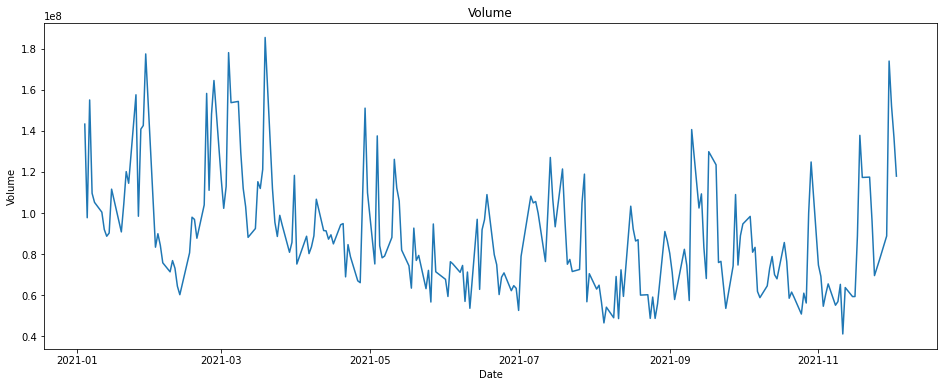

In [ ]:

plt.figure(figsize=(16,6))
plot_data = {'x' : df1.Date, 'y' : df1.Volume}     
plt.plot('x','y', data = plot_data)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume')
plt.show()


Plot the moving average of the company.
We will have 5 days, 10 days, till 30 days.
EWMA will be Exponentially Weighted Moving Average. It is a quantitative or statistical measure used to model or describe a time series. The EWMA is widely used in finance, the main applications being technical analysis and volatility modeling.



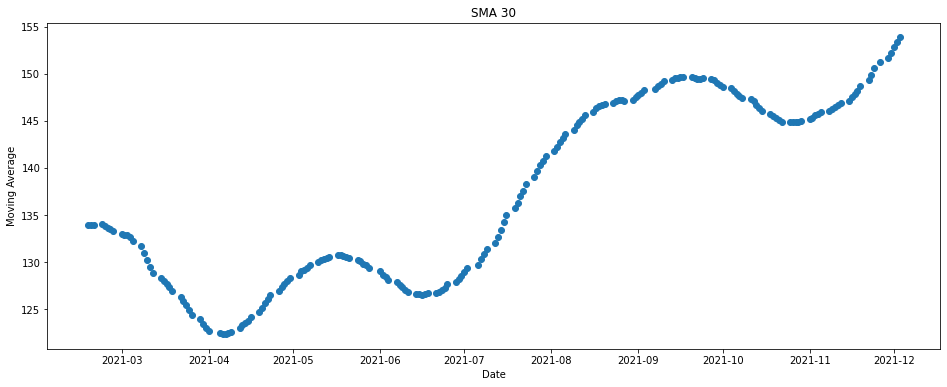

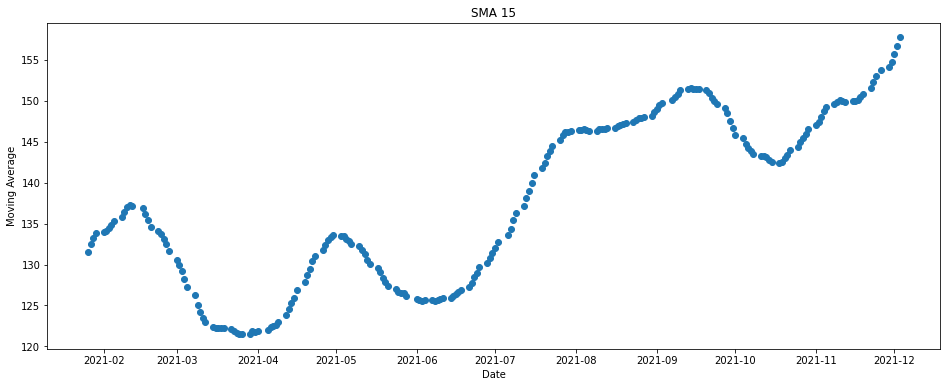

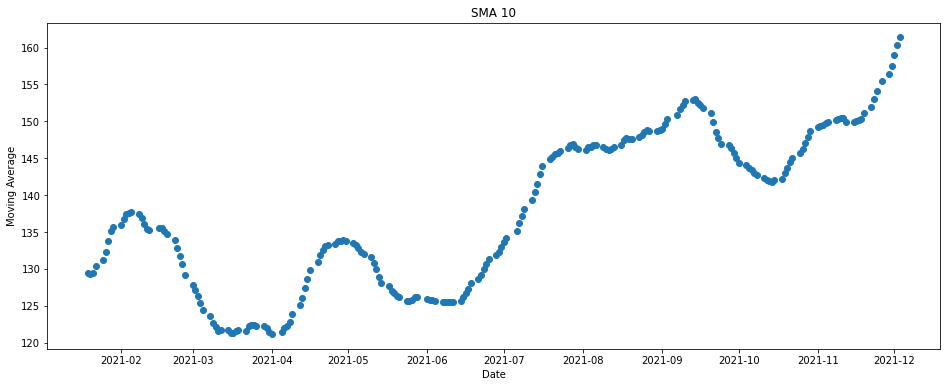

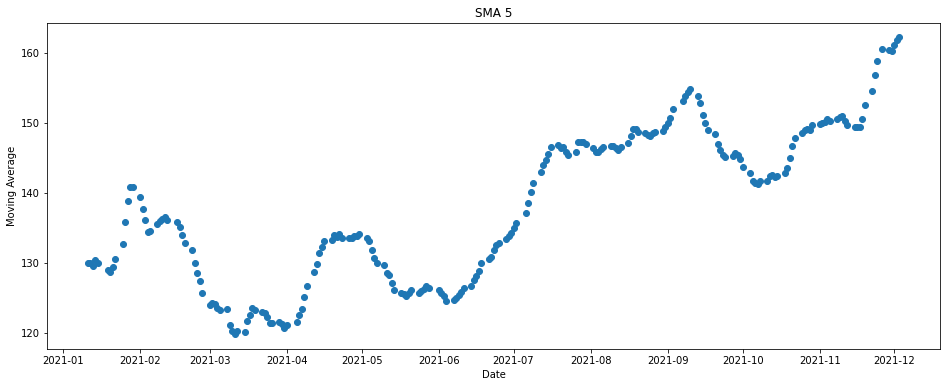

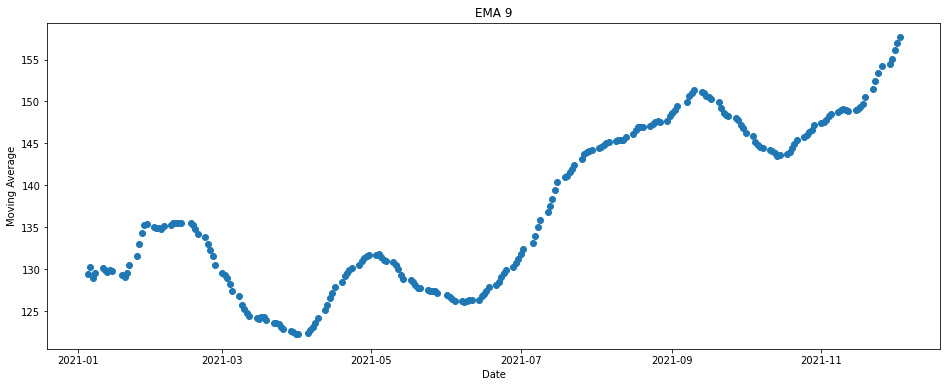

In [ ]:
df1['EMA_9'] = df1['Close'].ewm(9).mean().shift()
df1['SMA_5'] = df1['Close'].rolling(5).mean().shift()
df1['SMA_10'] = df1['Close'].rolling(10).mean().shift()
df1['SMA_15'] = df1['Close'].rolling(15).mean().shift()
df1['SMA_30'] = df1['Close'].rolling(30).mean().shift()

plot_data = {'x' : df1.Date, 'y' : df1.SMA_30} 
plt.figure(figsize=(16,6))
plt.scatter('x','y', data = plot_data)
plt.xlabel('Date')
plt.ylabel('Moving Average')
plt.title('SMA 30')
plt.show()

plot_data = {'x' : df1.Date, 'y' : df1.SMA_15} 
plt.figure(figsize=(16,6))
plt.scatter('x','y', data = plot_data)
plt.xlabel('Date')
plt.ylabel('Moving Average')
plt.title('SMA 15')
plt.show()

plot_data = {'x' : df1.Date, 'y' : df1.SMA_10}
plt.figure(figsize=(16,6))
plt.scatter('x','y', data = plot_data)
plt.xlabel('Date')
plt.ylabel('Moving Average')
plt.title('SMA 10')
plt.show()

plot_data = {'x' : df1.Date, 'y' : df1.SMA_5} 
plt.figure(figsize=(16,6))
plt.scatter('x','y', data = plot_data)
plt.xlabel('Date')
plt.ylabel('Moving Average')
plt.title('SMA 5')
plt.show()

plot_data = {'x' : df1.Date, 'y' : df1.EMA_9}  
plt.figure(figsize=(16,6))
plt.scatter('x','y', data = plot_data)
plt.xlabel('Date')
plt.ylabel('Moving Average')
plt.title('EMA 9')
plt.show()



In [ ]:
def relative_strength_idx(df1, n=14):
    close = df1['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df1['RSI'] = relative_strength_idx(df1).fillna(0)

In [ ]:
EMA_12 = pd.Series(df1['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df1['Close'].ewm(span=26, min_periods=26).mean())
df1['MACD'] = pd.Series(EMA_12 - EMA_26)
df1['MACD_signal'] = pd.Series(df1.MACD.ewm(span=9, min_periods=9).mean())

In [ ]:
df1['Close'] = df1['Close'].shift(-1)


In [ ]:
df1 = df1.iloc[33:] # Because of moving averages and MACD line
df1 = df1[:-1]      # Because of shifting close price

df1.index = range(len(df1))

**[Here](https://)** I split stock data frame into three subsets: training ( 70% ), validation ( 15% ) and test ( 15% ) sets. I calculated split indices and create three separate frames (train_df, valid_df, test_df). All three frames have been ploted in the chart below.

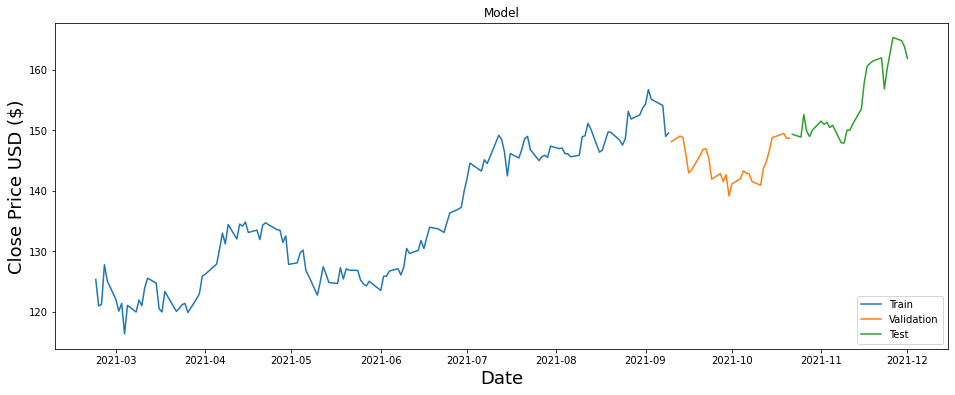

In [ ]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df1.shape[0] * (1-test_size))
valid_split_idx = int(df1.shape[0] * (1-(valid_size+test_size)))

train_df1  = df1.loc[:valid_split_idx].copy()
valid_df1  = df1.loc[valid_split_idx+1:test_split_idx].copy()
test_df1   = df1.loc[test_split_idx+1:].copy()


plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_df1.Date, train_df1['Close'])
plt.plot(valid_df1.Date, valid_df1['Close'])
plt.plot(test_df1.Date, test_df1['Close'])
plt.legend(['Train', 'Validation', 'Test'], loc='lower right')
plt.show()

Drop unnecessary columns.


In [ ]:
drop_cols = ['Date','Volume', 'Open', 'Low', 'High', 'Adj Close']

train_df1 = train_df1.drop(drop_cols, 1)
valid_df1 = valid_df1.drop(drop_cols, 1)
test_df1  = test_df1.drop(drop_cols, 1)

Split into features and labels.


In [ ]:
y_train = train_df1['Close'].copy()
X_train = train_df1.drop(['Close'], 1)

y_valid = valid_df1['Close'].copy()
X_valid = valid_df1.drop(['Close'], 1)

y_test  = test_df1['Close'].copy()
X_test  = test_df1.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        140 non-null    float64
 1   SMA_5        140 non-null    float64
 2   SMA_10       140 non-null    float64
 3   SMA_15       140 non-null    float64
 4   SMA_30       140 non-null    float64
 5   RSI          140 non-null    float64
 6   MACD         140 non-null    float64
 7   MACD_signal  140 non-null    float64
dtypes: float64(8)
memory usage: 8.9 KB


Implement XGBoost into our program

In [ ]:
import xgboost as xgb


parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
Best validation score = -1.4793420138368334


In [ ]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(gamma=0.02, learning_rate=0.05, max_depth=8, n_estimators=200,
             objective='reg:squarederror', random_state=42)

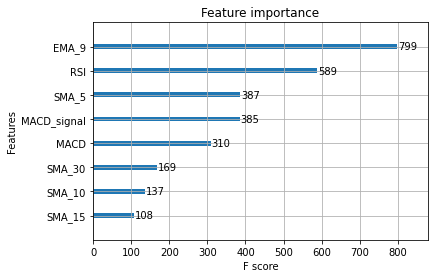

In [ ]:
plot_importance(model);


Predict the outcoming price.

In [ ]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:10]}')
print(f'y_pred = {y_pred[:10]}')

y_true = [149.320007 148.850006 152.570007 149.800003 148.960007 150.020004
 151.490005 150.960007 151.279999 150.440002]
y_pred = [145.88828 147.58485 148.58406 147.82448 147.7359  148.54916 149.2013
 151.72246 152.65169 153.0785 ]


In [ ]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')


ValueError: ignored

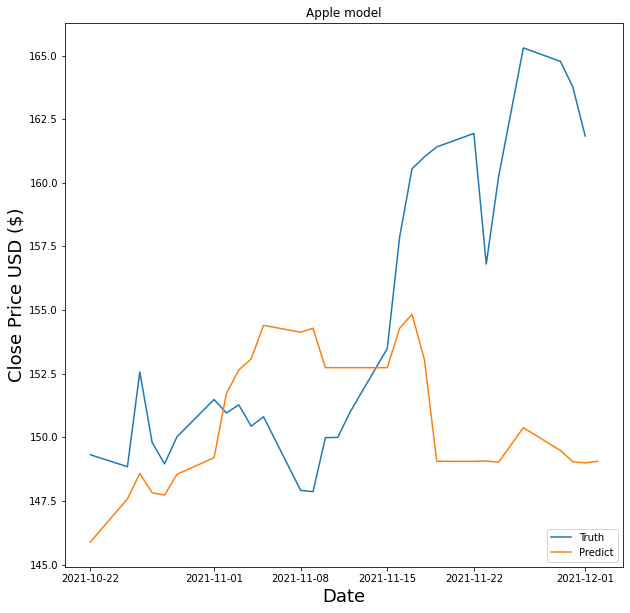

In [ ]:
predicted_prices = df1.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

x = predicted_prices['Date']

plt.figure(figsize=(10,10))
plt.title('Apple model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(x, y_test)
plt.plot(x ,y_pred )
plt.legend(['Truth', 'Predict'], loc='lower right')
plt.show()    